In [1]:
# We will try to use only 1 key value of y (y_min) as a feature, instead of using all of the values of y.
# There will be no noise in the values of y.

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
import seaborn as sns

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [4]:
def plot_the_loss_curve(epochs, mse_training, mse_validation):

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.plot(epochs[0:], mse_training[0:], label="Training Loss")
  plt.plot(epochs[0:], mse_validation[0:], label="Validation Loss")
  plt.legend()
  
  # We're not going to plot the first epoch, since the loss on the first epoch
  # is often substantially greater than the loss for other epochs.
  merged_mse_lists = mse_training[1:] + mse_validation[1:]
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
   
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show() 

In [5]:
l_min = 1
l_max = 1

n_l = 1  # defined only one value for L, for now.

# q in kN
q_min = 100
q_max = 500

n_q = 50

# E in GPa
E_min = 100
E_max = 350

n_E = 50

# I in dm^4
I_min = 1 * 10 ** 3 
I_max = 5 * 10 ** 3

n_I = 50

# Will make the vectors linearly spaced, but it's not necessary
l_vec = np.linspace(l_min, l_max, n_l)
q_vec = np.linspace(q_min, q_max, n_q)
E_vec = np.linspace(E_min, E_max, n_E)
I_vec = np.linspace(I_min, I_max, n_I)

In [6]:
# Compute all possible permutations and arrange them in a matrix

# Possibility to add noise to the values of q, E, I.
noise = 0.0

per_list = []
for i in range(len(l_vec)):
    for j in range(len(q_vec)):
        for k in range(len(E_vec)):
            for l in range(len(I_vec)):
                q_vec[j] = q_vec[j] + noise * (np.random.random() - 0.5) * (q_max - q_min)
                E_vec[k] = E_vec[k] + noise * (np.random.random() - 0.5) * (E_max - E_min)
                I_vec[l] = I_vec[l] + noise * (np.random.random() - 0.5) * (I_max - I_min)
                
                per_list = np.append(per_list, np.array([[l_vec[i], q_vec[j], E_vec[k], I_vec[l]]]))

per_list = per_list.reshape(-1, 4)

# Shuffle the permutations
np.random.shuffle(per_list)

np.save('125_combinations', per_list)  # saved as an .npy file to use later using np.load('125_combinations')

In [7]:
# analytical solution for the beam bending problem

def ana_sol(n, param_list):
    l=param_list[0]
    q=param_list[1]
    E=param_list[2]
    I=param_list[3]
    x_min = 0
    x_max = l
    x = np.linspace(x_min, x_max, n)
    y = np.zeros(len(x))
    c_1 = -(q * 10 ** 3 * l ** 3) / (24 * E * 10 ** 9 * I * 10 ** (-8))
    y = (1 / (E * 10 ** 9 * I * 10 ** (-8))) * (((q * 10 ** 3 * l) / 12) * x ** 3 - (q * 10 ** 3 / 24) * x ** 4) + c_1 * x

    return [x, y]

def ana_sol_with_noise(n, param_list,noise):
    l=param_list[0]
    q=param_list[1]
    E=param_list[2]
    I=param_list[3]
    x_min = 0
    x_max = l
    x = np.linspace(x_min, x_max, n)
    y = np.zeros(len(x))
    c_1 = -(q * 10 ** 3 * l ** 3) / (24 * E * 10 ** 9 * I * 10 ** (-8))
    y = (1 / (E * 10 ** 9 * I * 10 ** (-8))) * (((q * 10 ** 3 * l) / 12) * x ** 3 - (q * 10 ** 3 / 24) * x ** 4) + c_1 * x
    y = y + noise * (np.random.random(len(y)) - 0.5) * (np.max(y) - np.min(y))

    return [x, y]

In [8]:
#alternative way to generate fake data with noise
n = 1000
# Add noise
noise_factor = 0.0
#create dictionary with generated data
fake_data = {}
#dict keys: list of parameters values
#dict values: (x,y) array 
for i in per_list:
    fake_data[repr(i.tolist())] = ana_sol_with_noise(n, i, noise_factor)

In [9]:
#for each entry combination of (l,q,E,I) we have two columns of fake data: both x and noisy y 
fake_dataframe=pd.DataFrame.from_dict(fake_data,orient='index',columns=['x', 'y'])
#I will now dstructure the data in such a way that we are able to immediatly assess 
# which entry combination of (l,q,E,I) gives a specific (x,Y)
#let's clean a little
fake_dataframe=fake_dataframe.rename_axis('parameters').reset_index()
fake_dataframe.parameters=[eval(fake_dataframe.parameters[i]) for i in range(len(fake_dataframe))]
fake_dataframe[['l','q','E','I']] = pd.DataFrame(fake_dataframe.parameters.tolist(), index= fake_dataframe.index)
fake_dataframe=fake_dataframe.drop(columns='parameters')
#let's see an example of structured data
fake_dataframe

,x,y,l,q,E,I
0,"[0.0, 0.001001001001001001, 0.0020020020020020...","[0.0, -2.6462850296470165e-06, -5.292538277363...",1.0,467.346939,166.326531,4428.571429
1,"[0.0, 0.001001001001001001, 0.0020020020020020...","[0.0, -5.279673067034556e-06, -1.0559282725100...",1.0,410.204082,135.714286,2387.755102
2,"[0.0, 0.001001001001001001, 0.0020020020020020...","[0.0, -4.565583105209274e-06, -9.1311113776831...",1.0,344.897959,181.632653,1734.693878
3,"[0.0, 0.001001001001001001, 0.0020020020020020...","[0.0, -4.640253646173909e-06, -9.2804515628179...",1.0,451.020408,105.102041,3857.142857
4,"[0.0, 0.001001001001001001, 0.0020020020020020...","[0.0, -1.2445362317877192e-06, -2.489057516672...",1.0,328.571429,258.163265,4265.306122
...,...,...,...,...,...,...
124995,"[0.0, 0.001001001001001001, 0.0020020020020020...","[0.0, -2.5028904084139396e-06, -5.005750757068...",1.0,344.897959,145.918367,3938.775510
124996,"[0.0, 0.001001001001001001, 0.0020020020020020...","[0.0, -6.458263290954017e-06, -1.2916449018049...",1.0,295.918367,135.714286,1408.163265
124997,"[0.0, 0.001001001001001001, 0.0020020020020020...","[0.0, -1.8749598931061376e-06, -3.749897267910...",1.0,361.224490,222.448980,3612.244898
124998,"[0.0, 0.001001001001001001, 0.0020020020020020...","[0.0, -1.7201157266925703e-06, -3.440210794764...",1.0,353.061224,196.938776,4346.938776


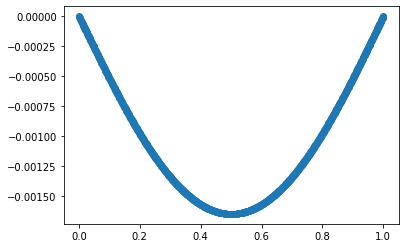

In [10]:
#plot the 1st entry of the dataframe
plt.scatter(fake_dataframe['x'][1],fake_dataframe['y'][1],label=str(fake_dataframe.index[1]))
plt.show()

In [11]:
#with the dataset organized is much easier to split the data.
#https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test
#let's take a look at an example 
test_split=0.1 #we will use 10% of the data for testing. 
df = fake_dataframe
train_df, test_df = train_test_split(df, test_size = test_split)

In [12]:
#the training data will be spllited automatically by 80/20 during training using keras framework. 
# no need to split at this stage.
#let's check the array shapes: 
print('Training set: ',train_df.shape)
print('Test set: ',test_df.shape)

train_size = train_df.shape[0]
test_size = test_df.shape[0]

Training set:  (112500, 6)
Test set:  (12500, 6)


C:\Users\luisf\.conda\envs\tf\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


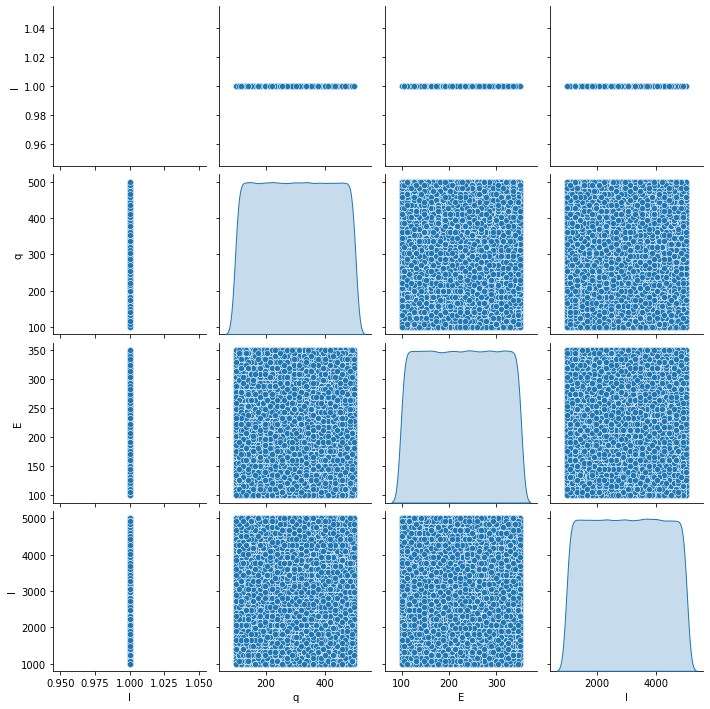

In [13]:
#inspect the training dataset
sns.pairplot(train_df[['l', 'q', 'E', 'I']], diag_kind='kde')

In [14]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
l,112500.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.0
q,112500.0,299.946957,117.824576,100.0,197.959184,295.918367,402.040816,500.0
E,112500.0,225.007937,73.634768,100.0,161.224490,227.551020,288.775510,350.0
I,112500.0,2999.517460,1177.247722,1000.0,1979.591837,2959.183673,4020.408163,5000.0


In [15]:
# follow this tutorial for our data 
# https://www.tensorflow.org/tutorials/keras/regression
# whenever possible, add comments and discussion

In [16]:
# I have fixed the value of L as 1.0 for now, so I am not using the values of [x,y] as inputs, only the values of y.

In [17]:
# Allocate the features and the labels in different DataFrames.

train_features = train_df.copy()
test_features = test_df.copy()

# train_labels = pd.DataFrame([train_features.pop('l'), train_features.pop('q'), train_features.pop('E'), train_features.pop('I')])
# train_labels = train_labels.T
# test_labels = pd.DataFrame([test_features.pop('l'), test_features.pop('q'), test_features.pop('E'), test_features.pop('I')])
# test_labels = test_labels.T

train_labels = pd.DataFrame([train_features.pop('q'), train_features.pop('E'), train_features.pop('I')])
train_labels = train_labels.T
test_labels = pd.DataFrame([test_features.pop('q'), test_features.pop('E'), test_features.pop('I')])
test_labels = test_labels.T

In [18]:
y_min_train = np.zeros(train_size)
y_min_test = np.zeros(test_size)


y_array_train = train_df.y.to_numpy()

for i in range(train_size):
    y_min_train[i] = np.min(y_array_train[i])

y_array_test = test_df.y.to_numpy()

for i in range(test_size):
    y_min_test[i] = np.min(y_array_test[i])

In [58]:
# Build the model and define its architecture.

In [59]:
inputs = keras.Input(shape=1)

In [60]:
dense = layers.Dense(256, activation="relu")
x = dense(inputs)

In [61]:
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(3)(x)

In [62]:
model = keras.Model(inputs=inputs, outputs=outputs, name="model")

In [63]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               512       
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 771       
Total params: 67,075
Trainable params: 67,075
Non-trainable params: 0
_________________________________________________________________


In [64]:
# Set the hyperparameters

validation_split = 0.2
learning_rate = 0.001
batch_size = 50
epochs = 30

In [65]:
model.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
)

# Still need to find what's the best loss function for our model.

In [66]:
# For some reason I had to manually convert the data into tensors.

tf_train_features = tf.constant(y_min_train)

tf_train_labels = tf.constant([np.array(train_labels)], shape=(train_size,3))

tf_test_features = tf.constant(y_min_test)

tf_test_labels = tf.constant([np.array(test_labels)], shape=(test_size,3))

In [67]:
history = model.fit(tf_train_features, tf_train_labels, batch_size=batch_size, epochs=epochs, validation_split=validation_split)

test_scores = model.evaluate(tf_train_features, tf_train_labels, verbose=2)
print("Test loss:", test_scores)

Epoch 1/30
1800/1800 [==============================] - 5s 3ms/step - loss: 930980.8125 - val_loss: 460550.0625
Epoch 2/30
1800/1800 [==============================] - 5s 3ms/step - loss: 468750.3438 - val_loss: 458821.0312
Epoch 3/30
1800/1800 [==============================] - 5s 3ms/step - loss: 466830.2812 - val_loss: 456753.0625
Epoch 4/30
1800/1800 [==============================] - 5s 3ms/step - loss: 464900.0625 - val_loss: 454427.3438
Epoch 5/30
1800/1800 [==============================] - 5s 3ms/step - loss: 462511.8438 - val_loss: 452079.7188
Epoch 6/30
1800/1800 [==============================] - 4s 2ms/step - loss: 460010.6875 - val_loss: 449371.5312
Epoch 7/30
1800/1800 [==============================] - 4s 2ms/step - loss: 457075.6875 - val_loss: 446468.3125
Epoch 8/30
1800/1800 [==============================] - 5s 3ms/step - loss: 453549.0000 - val_loss: 442228.6875
Epoch 9/30
1800/1800 [==============================] - 5s 3ms/step - loss: 448880.1875 - val_loss: 4375

178552.65625


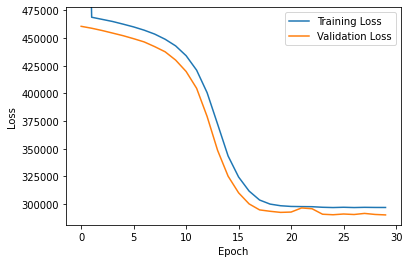

In [68]:
epochs = history.epoch

hist = history.history

plot_the_loss_curve(epochs, hist["loss"], 
                    hist["val_loss"])

In [69]:
tf_test_labels[0:5]

# q; E; I

<tf.Tensor: shape=(5, 3), dtype=float64, numpy=
array([[ 344.89795918,  202.04081633, 3122.44897959],
       [ 108.16326531,  110.20408163, 1163.26530612],
       [ 393.87755102,  329.59183673, 3367.34693878],
       [ 402.04081633,  242.85714286, 3693.87755102],
       [ 328.57142857,  196.93877551, 1408.16326531]])>

In [70]:
guesses = model.predict(tf_test_features)

guesses[0:5]
# q; E; I

array([[ 335.59494,  225.27336, 2927.5217 ],
       [ 377.5589 ,  198.80498, 2412.1907 ],
       [ 275.77634,  246.00246, 3385.5667 ],
       [ 305.74902,  235.83327, 3159.6047 ],
       [ 406.24078,  171.66812, 1912.8486 ]], dtype=float32)

In [71]:
# relative error (%)

(np.abs(tf_test_labels[0:5] - model.predict(tf_test_features)[0:5]) / tf_test_labels[0:5]) * 100

<tf.Tensor: shape=(5, 3), dtype=float64, numpy=
array([[  2.69732503,  11.49893635,   6.24276817],
       [249.06388769,  80.39710914, 107.36375968],
       [ 29.98424613,  25.36148374,   0.54107022],
       [ 23.95075052,   2.89218409,  14.46373918],
       [ 23.63849938,  12.83173113,  35.83997537]])>

In [72]:
error_mat = (np.abs(tf_test_labels - model.predict(tf_test_features)) / tf_test_labels) * 100

error_avg = np.array([0,0,0])
error_avg[0] = np.average(error_mat[:,0])
error_avg[1] = np.average(error_mat[:,1])
error_avg[2] = np.average(error_mat[:,2])

error_avg

# average relative error (%) for [q, E, I]

array([34, 28, 31])

In [73]:
def compare_curves(label, guess, n):

    label = [1, label[0], label[1],label[2]]
    guess = [1, guess[0], guess[1], guess[2]]
    
    x_vec = np.linspace(0, 1, n)
    y_vec = ana_sol(n, label)[1] * 10**3  # [mm]

    points = np.zeros((len(x_vec), 2))

    for i in range(len(x_vec)):
        points[i, 0] = x_vec[i]
        points[i, 1] = y_vec[i]
    
    y_vec_g = ana_sol(n, guess)[1] * 10**3  # [mm]

    points = np.zeros((len(x_vec), 2))

    for i in range(len(x_vec)):
        points[i, 0] = x_vec[i]
        points[i, 1] = y_vec[i]


    plt.plot(x_vec, y_vec, c='g')
    plt.plot(x_vec, y_vec_g, c='r')
    plt.show()

In [74]:
# error_col will contain the average of the relative errors (%) for q, E and I for each guess.

error_col = (error_mat[:,0] + error_mat[:,1] + error_mat[:,2])/3

In [75]:
np.average(error_col)

31.451602128590363

In [76]:
np.std(error_col)

22.490249772175556

In [77]:
np.max(error_col)

164.44251163815989

In [78]:
np.min(error_col)

0.520262224431912

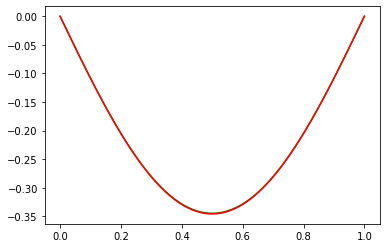

In [79]:
# This is the best guess (the guess which as the minimum average error)
# "True" curve is in green, whereas the "guessed" curve is in red.

min_label = np.array(tf_test_labels[np.argmin(error_col),:])
min_guess = model.predict(tf_test_features)[np.argmin(error_col),:]

compare_curves(min_label, min_guess, n)

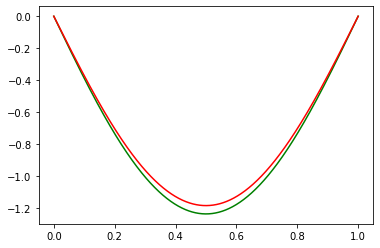

In [80]:
# This is the worst guess (the guess which as the maximum average error)

max_label = tf_test_labels[np.argmax(error_col),:]
max_guess = model.predict(tf_test_features)[np.argmax(error_col),:]

compare_curves(max_label, max_guess, n)

In [81]:
# We will use the relative error for the minimum value of y to evaluate the quality of the curves.

guess_curves = np.zeros([np.size(guesses, 0), n])
true_curves = np.zeros([np.size(guesses, 0), n])

for i in range(np.size(guesses, 0)):
    parameter_list = [1, guesses[i, 0], guesses[i,1], guesses[i,2]]
    guess_curves[i] = ana_sol(n, parameter_list)[1]
    
for i in range(np.size(guesses, 0)):
    true_parameter_list = [1, tf_test_labels[i, 0], tf_test_labels[i,1], tf_test_labels[i,2]]
    true_curves[i] = ana_sol(n, true_parameter_list)[1]
    
delta_y = np.abs(np.min(guess_curves, axis = 1) - np.min(true_curves, axis = 1))
rel_err_y = np.abs(delta_y / np.min(true_curves, axis = 1)) * 100

In [82]:
error_avg

array([34, 28, 31])

In [83]:
np.average(error_col)

31.451602128590363

In [84]:
np.std(error_col)

22.490249772175556

In [85]:
np.max(error_col)

164.44251163815989

In [86]:
np.min(error_col)

0.520262224431912

In [87]:
np.average(rel_err_y)

9.86724148415096

In [88]:
np.std(rel_err_y)

14.062613220607886

In [89]:
np.max(rel_err_y)

157.95955940365903

In [90]:
np.min(rel_err_y)

0.0009526976555844091

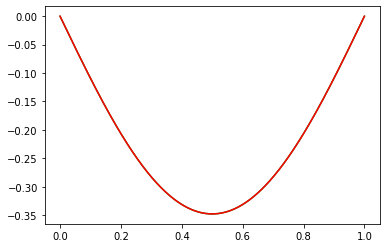

In [91]:
# Best curve

i_min_err = np.argmin(rel_err_y)
compare_curves(tf_test_labels[i_min_err,:], model.predict(tf_test_features)[i_min_err, :], n)

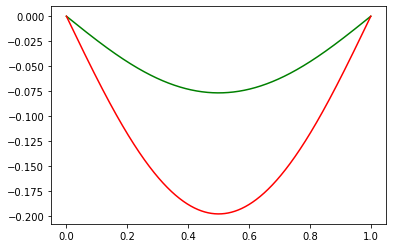

In [92]:
# Worst curve

i_max_err = np.argmax(rel_err_y)
compare_curves(tf_test_labels[i_max_err,:], model.predict(tf_test_features)[i_max_err ,:], n)

In [93]:
# 20x20x20 combinations: average from 3 runs

# Rel. Error for [q, E, I]: [38.0, 28.0, 32.0](%) 

# Average Rel. Error:       33.30%
# Std for Rel. Error:       22.09%
# Max Rel. Error:           160.58%
# Min Rel. Error:           2.17%

# Rel. Error for y_min:     22.12%
# Std for y_min:            28.08%
# Max Rel. Error for y_min: 240.98%
# Min Rel. Error for y_min: 0.0093%

In [94]:
# 50x50x50 combinations: average from 3 runs

# Rel. Error for [q, E, I]: [31.3, 27.7, 31.3](%) 

# Average Rel. Error:       30.81%
# Std for Rel. Error:       21.33%
# Max Rel. Error:           157.06%
# Min Rel. Error:           0.97%

# Rel. Error for y_min:     12.23%
# Std for y_min:            11.93%
# Max Rel. Error for y_min: 326.85%
# Min Rel. Error for y_min: 0.0014%

In [95]:
# 80x80x80 combinations: average from 3 runs

# Rel. Error for [q, E, I]: [31.3, 27.0, 31.7](%) 

# Average Rel. Error:       30.26%
# Std for Rel. Error:       21.15%
# Max Rel. Error:           157.52%
# Min Rel. Error:           0.49%

# Rel. Error for y_min:     7.84%
# Std for y_min:            9.47%
# Max Rel. Error for y_min: 204.39%
# Min Rel. Error for y_min: 0.00015%

In [96]:
# It appears that we were able to get acceptable accuracy in this experiment, altough slightly lower when compared to
# the regular model where we use all values of y (for the same number of [q, E, I] combinations).

# Running time is greatly reduced.

# This works very well in this case, but probably only because the beam is allways simetrical for this kind of load
# and the only key point is the minimum value of y.